In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import random
import math
import helper
import importlib
import h5py
import kapre
from kapre.composed import get_melspectrogram_layer
#from netplot import ModelPlot # this fucking library uses a weird version of numpy so we are not gonna use it
from tensorflow.keras.utils import plot_model
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import *#Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# set the random seed
tf.random.set_seed(42)
np.random.seed(42)

# are we resuming training?
resume = False

2.8.0
Num GPUs Available:  1


In [8]:
# get the data set root directory path
dataset_root_dir = os.path.join("/home/charlesedwards/Documents", 'kaggle_2018_dataset')

# get the train and test data directories
train_dir = os.path.join(dataset_root_dir, 'train')
test_dir = os.path.join(dataset_root_dir, 'test')

# get the catalog.csv for train and test directories
train_catalog_csv = os.path.join(train_dir, 'catalog.csv')
test_catalog_csv = os.path.join(test_dir, 'catalog.csv')

# read the catalog.csv files
train_metadata = pd.read_csv(train_catalog_csv)
test_metadata = pd.read_csv(test_catalog_csv)

# drop unwanted columns 
train_metadata.drop(['license','freesound_id'], axis=1, inplace=True)
test_metadata.drop(['license','freesound_id'], axis=1, inplace=True)

# the cached feature extraction data root folder
data_npy_folder = os.path.join(dataset_root_dir, 'data')

# # load in pre-processed MFCC train data
# X = np.load( os.path.join(data_npy_folder, "X-cache-merged.npy" ), allow_pickle=True )
# y = np.load( os.path.join(data_npy_folder, "y-cache-merged.npy" ), allow_pickle=True )

#X = np.asarray(X).astype('float32') # quircky fix if it works https://stackoverflow.com/questions/58636087/tensorflow-valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupporte
#X = np.asarray(X).astype(np.float32)

# display the first 5 rows of both metadatas
helper.display_side_by_side([train_metadata.head(),test_metadata.head()], ['train_metadata', 'test_metadata'])

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1
,fname,label,usage
0,00326aa9.wav,Oboe,Private
1,0038a046.wav,Bass_drum,Private
2,007759c4.wav,Saxophone,Private
3,008afd93.wav,Saxophone,Private


In [9]:
print(len(train_metadata.index))
# merge train_metadata and test_metadata
metadata = pd.concat([train_metadata, test_metadata])
print(len(metadata.index))
metadata.head()

9473
11073


,fname,label,manually_verified,usage
0,00044347.wav,Hi-hat,0.0,NaN
1,001ca53d.wav,Saxophone,1.0,NaN
2,002d256b.wav,Trumpet,0.0,NaN
3,0033e230.wav,Glockenspiel,1.0,NaN
4,00353774.wav,Cello,1.0,NaN


In [10]:
list_wavs = []
list_labels = []

for index, row in metadata.iterrows():

    target_file = ""
    # detect if row["usage"] is NaN
    #print(str(row["usage"]).lower())
    if str(row["usage"]).lower() == "nan":
        # if nan its a test train
        target_file = os.path.join( train_dir, row['fname'] )
    else:
        target_file = os.path.join( test_dir, row['fname'] )

    list_wavs.append(target_file)
    list_labels.append(row['label'])

In [11]:
le = LabelEncoder()

labels = le.fit_transform(list_labels)#le.transform(list_labels)

wav_train, wav_val, label_train, label_val = train_test_split(
    list_wavs,
    labels,
    test_size=0.2,
    random_state=0
)

N_CLASSES = len(le.classes_)

# from metadata get the unique labels
#unique_labels = metadata['label']#.unique()

# # list all the labels from metadata
# list_labels = metadata['label'].tolist()

# list_labels

# #labels = le.fit(unique_labels)
# labels = le.transform(list_labels)

# wav_train, wav_val, label_train, label_val = train_test_split(
#     list_wavs,
#     labels,
#     test_size=0.2,
#     random_state=0
# )

# 

# # encode the labels to categorical
# le = LabelEncoder()

# #y_train_encoded = to_categorical(le.fit_transform(y_train))
# #unique_labels = np.unique(y)



# #y_test_encoded = to_categorical(le.fit_transform(y))
# y_test_encoded = to_categorical(le.fit_transform(unique_labels))

# # get total of unique labels from Y
# N_CLASSES = len(le.classes_)#unique_labels#y_train_encoded.shape[1]
N_CLASSES, len(le.classes_), le.classes_

(41,
 41,
 array(['Acoustic_guitar', 'Applause', 'Bark', 'Bass_drum',
        'Burping_or_eructation', 'Bus', 'Cello', 'Chime', 'Clarinet',
        'Computer_keyboard', 'Cough', 'Cowbell', 'Double_bass',
        'Drawer_open_or_close', 'Electric_piano', 'Fart',
        'Finger_snapping', 'Fireworks', 'Flute', 'Glockenspiel', 'Gong',
        'Gunshot_or_gunfire', 'Harmonica', 'Hi-hat', 'Keys_jangling',
        'Knock', 'Laughter', 'Meow', 'Microwave_oven', 'Oboe', 'Saxophone',
        'Scissors', 'Shatter', 'Snare_drum', 'Squeak', 'Tambourine',
        'Tearing', 'Telephone', 'Trumpet', 'Violin_or_fiddle', 'Writing'],
       dtype='<U21'))

In [12]:
DELTA_TIME = 1
SAMPLE_RATE = 22050

BATCH_SIZE = 32
EPOCHS = 30 # standard we are training for 500 epochs

In [13]:
from scipy.io import wavfile

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, wav_paths, labels, sr, dt, n_classes,
                 batch_size=32, shuffle=True):
        self.wav_paths = wav_paths
        self.labels = labels
        self.sr = sr
        self.dt = dt
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = True
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.wav_paths) / self.batch_size))


    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        wav_paths = [self.wav_paths[k] for k in indexes]
        labels = [self.labels[k] for k in indexes]

        # generate a batch of time data
        X = np.empty((self.batch_size, int(self.sr*self.dt), 1), dtype=np.float32)
        Y = np.empty((self.batch_size, self.n_classes), dtype=np.float32)

        for i, (path, label) in enumerate(zip(wav_paths, labels)):
            rate, wav = wavfile.read(path) # data was path
            # # read in file from path mono
            sample = None
            #rate, wav = helper.downsample_mono(path, SAMPLE_RATE)
            #mask, y_mean = helper.envelope(wav, SAMPLE_RATE, threshold=args.threshold)
            #wav = wav[mask]
            delta_sample = int(DELTA_TIME*SAMPLE_RATE)

            # cleaned audio is less than a single sample
            #wav pad with zeros to delta_sample size
            if wav.shape[0] < delta_sample:
                sample = np.zeros(shape=(delta_sample,), dtype=np.int16)
                sample[:wav.shape[0]] = wav
                #save_sample(sample, rate, target_dir, fn, 0)
            # step through audio and save every delta_sample
            # discard the ending audio if it is too short
            else:
                trunc = wav.shape[0] % delta_sample
                for cnt, i in enumerate(np.arange(0, wav.shape[0]-trunc, delta_sample)):
                    start = int(i)
                    stop = int(i + delta_sample)
                    sample = wav[start:stop]
                    #save_sample(sample, rate, target_dir, fn, cnt)

            #wav, rate = librosa.load(path, mono=True, sr=self.sr)
            X[i,] = sample.reshape(-1, 1)#np.array(sample).reshape(-1, 1)
            Y[i,] = to_categorical(label, num_classes=self.n_classes)

        return X, Y


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.wav_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [14]:

# train data generator
tg = DataGenerator(
    wav_train, 
    label_train, 
    SAMPLE_RATE, 
    DELTA_TIME,
    N_CLASSES, batch_size=BATCH_SIZE
)

vg = DataGenerator(
    wav_val, 
    label_val, 
    SAMPLE_RATE, 
    DELTA_TIME,
    N_CLASSES, batch_size=BATCH_SIZE
)

In [15]:
if resume is False:

    input_shape = (int(SAMPLE_RATE*DELTA_TIME), 1)
    i = get_melspectrogram_layer(
        input_shape=input_shape,
        n_mels=128,
        pad_end=True,
        n_fft=512,
        win_length=400,
        hop_length=160,
        sample_rate=SAMPLE_RATE,
        return_decibel=True,
        input_data_format='channels_last',
        output_data_format='channels_last'
    )
    x = LayerNormalization(axis=2, name='batch_norm')(i.output)
    x = TimeDistributed(Conv1D(8, kernel_size=(4), activation='tanh'), name='td_conv_1d_tanh')(x)
    x = MaxPooling2D(pool_size=(2,2), name='max_pool_2d_1')(x)
    x = TimeDistributed(Conv1D(16, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_1')(x)
    x = MaxPooling2D(pool_size=(2,2), name='max_pool_2d_2')(x)
    x = TimeDistributed(Conv1D(32, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_2')(x)
    x = MaxPooling2D(pool_size=(2,2), name='max_pool_2d_3')(x)
    x = TimeDistributed(Conv1D(64, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_3')(x)
    x = MaxPooling2D(pool_size=(2,2), name='max_pool_2d_4')(x)
    x = TimeDistributed(Conv1D(128, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_4')(x)
    x = GlobalMaxPooling2D(name='global_max_pooling_2d')(x)
    x = Dropout(rate=0.1, name='dropout')(x)
    x = Dense(64, activation='relu', activity_regularizer=l2(0.001), name='dense')(x)
    o = Dense(N_CLASSES, activation='softmax', name='softmax')(x)
    model = Model(inputs=i.input, outputs=o, name='1d_convolution')


2022-02-22 00:34:13.814229: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-22 00:34:13.815838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 00:34:13.816325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 00:34:13.816706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [16]:
# 2. compile the model
if resume is False:

    learning_rate=0.001
    beta_1=0.9
    beta_2=0.999
    epsilon=1e-07
    
    model.compile(
        loss = "categorical_crossentropy", # mean absolute error predicted vs observed
        # previous failure training used 1e-4, beta_1=0.99, beta_2=0.999, only achieved a val_loss did not improve from 0.04701
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon), # stochastic gradient descent (lr=1e-3)
        metrics=['accuracy'] # metrics accuracy
    )

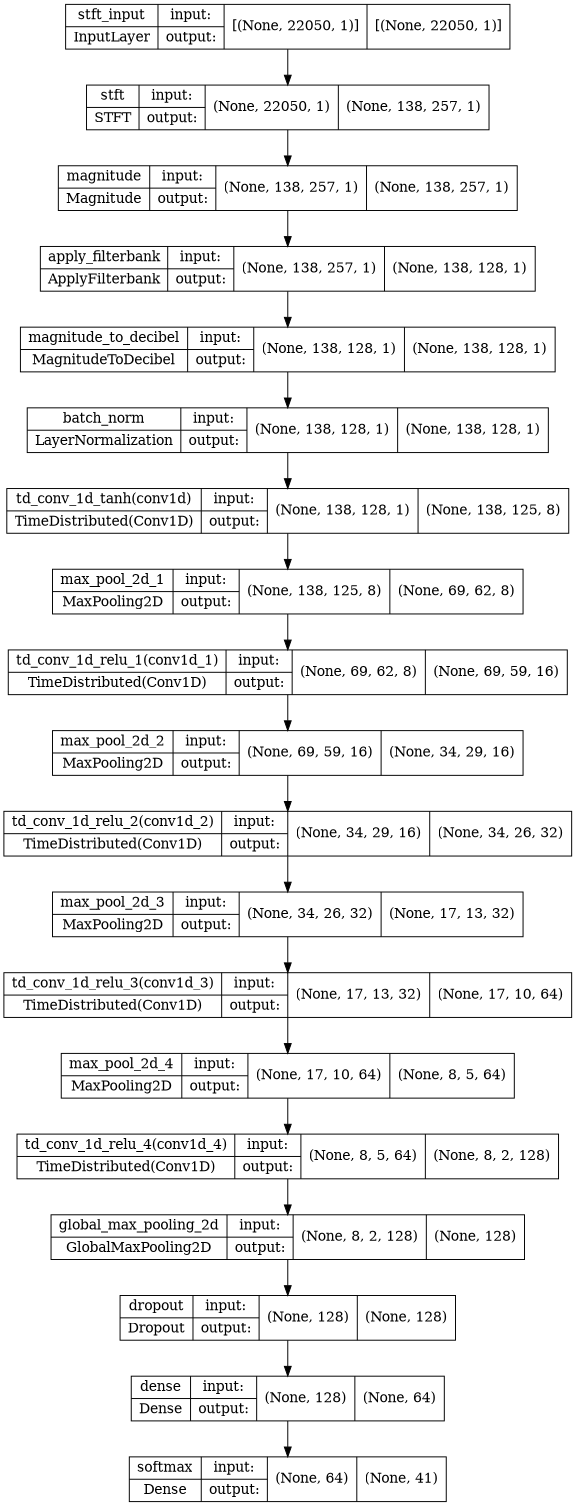

In [17]:
# plot model
#model.build()
plot_model(model, show_shapes=True, expand_nested=True, dpi=70)

In [18]:
# set the model path
model_dir = os.path.join( dataset_root_dir, 'models')

if resume is False:
    # this is where we will save the model too
    model_path = os.path.join(model_dir, f'KAPRE-MEL-CONV1D_lr-{learning_rate}_b1-{beta_1}_b2-{beta_2}_epsilon-{epsilon}_MAX_EPOCH-{EPOCHS}_BATCH-{BATCH_SIZE}.h5')
# else:
#     num_epochs = 500
#     num_batch_size = 64#32 # recommend keeping same as saved model
#     print("Resuming training...")
#     model_path = os.path.join(model_dir, 'CONV2D_CNN-lr-0.0001_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v8.h5')
#     # Load best saved model
#     print("Loading best saved model...")
#     model = load_model(model_path)

model_path

'/home/charlesedwards/Documents/kaggle_2018_dataset/models/KAPRE-MEL-CONV1D_lr-0.001_b1-0.9_b2-0.999_epsilon-1e-07_MAX_EPOCH-30_BATCH-32.h5'

In [19]:
# Save checkpoints
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path, 
    verbose=1, 
    save_best_only=True
)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10#10#/*#15#6#3
)

start = datetime.now()

# 3. train the model
history = model.fit(
    tg, 
    validation_data=vg,
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    #validation_split=1/12.,
    #shuffle=True, # shuffle training data
    callbacks=[checkpointer, early_stopping_callback], 
    verbose=1
)

end = datetime.now() - start
print("Training time: {}".format(end))

IndexError: index 22050 is out of bounds for axis 0 with size 32

Text(0.5, 0, 'epochs')

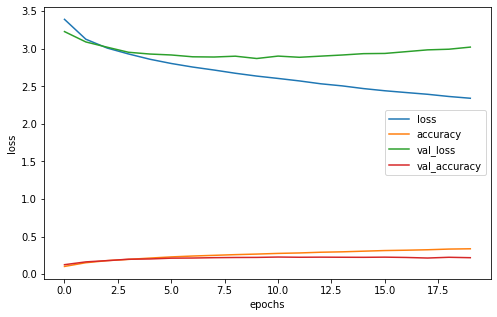

In [ ]:
# plot history also known as loss curve 
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.ylabel("loss")
plt.xlabel("epochs")

In [ ]:

model.metrics_names

['loss', 'accuracy']

In [ ]:
# # set the model path
# model_dir = os.path.join( dataset_root_dir, 'models')
# #model_path = os.path.join(model_dir, "V3/RESNET")
# model_path = os.path.join(model_dir, f'CONV2D_CNN-lr-0.001_b1-0.99_b2-0.999_EPOCH-500_BATCH-32 terrible.h5')

# from kapre.time_frequency import STFT, Magnitude, ApplyFilterbank, MagnitudeToDecibel

# model = load_model(model_path,custom_objects={'STFT':STFT,
#                         'Magnitude':Magnitude,
#                         'ApplyFilterbank':ApplyFilterbank,
#                         'MagnitudeToDecibel':MagnitudeToDecibel})

In [ ]:
# importlib.reload(helper)
# helper.model_evaluation_report(model, wav_train, label_train, wav_val, label_val)

In [ ]:

# importlib.reload(helper)

# # Sets decimal precision (for printing output only)
# np.set_printoptions(precision=2)

# # Predict probabilities for test set
# y_probs = model.predict(X_test, verbose=0)

# # Get predicted labels
# yhat_probs = np.argmax(y_probs, axis=1)
# y_trues = np.argmax(y_test_encoded, axis=1)

# # Compute confusion matrix data
# cm = confusion_matrix(y_trues, yhat_probs)

# helper.plot_confusion_matrix(
#     cm=cm,
#     classes=le.classes_.tolist(),
#     normalized=False, 
#     title=f"Model Performance\n{model_path.split('/')[-1]}", 
#     cmap=plt.cm.Blues,
#     size=(12,12))